# Practical Session 2

#### Soufiane MOUTEI

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<div class="alert alert-success">
<span class="label label-success" style="font-size:15px;">Question 1</span><br><br>
    In Gaussian Mixture Models, we often need to evaluate quantities that are defined as follows:
    <br>
    $$
    \gamma_i (x) = \frac{\pi_i \mathcal{N}(x; \mu_i, \Sigma_i)}{\sum_{j=1}^{K}  {\pi_j \mathcal{N}(x; \mu_j, \Sigma_j)}}
    $$
    
    where $\pi_i \in [0, 1]$ and $\mathcal{N}$ denotes the multivariate Gaussian distribution. A direct computation of these quantities might be problematic in practice since all the terms ($\pi_i \mathcal{N}(x; \mu_i, \Sigma_i)$) might be very small, and we might end up with $0/0$. Derive mathematically (don’t try to take the derivative!) and implement a function for numerically stable computation of $\{\gamma_i\}_{i=1}^K$.<br>
Hint: first compute $l_i = \log \pi_i \mathcal{N}(x; \mu_i, \Sigma_i)$ in a numerically stable way (be careful when computing $\log \det \Sigma_i$). Then use a trick similar to the one we used for ‘log sum exp’.
</div>

In [2]:
def log_normal(x, mu, sigma):
    """
    The logarithm of the normal distribution
    
    Parameters
    ----------
    x : `numpy.array`, shape (N, m=2)
        The data point
    
    mu : `numpy.array`, shape (K, m)
        The means of the gaussians
        
    sigma : `numpy.array`, shape (K, m, m)
        The covariances of the gaussians
    """
    K = mu.shape[0]
    
    # Calculating: (x-mu).T inv(sigma) (x-mu)
    tmp = x - mu
    tmp2 = np.array([tmp[k].T.dot(np.linalg.inv(sigma[k]).dot(tmp[k])) for k in range(K)])
    
    return -0.5 * (
        np.linalg.slogdet(sigma)[1] 
        + K*np.log(2*np.pi)
        + tmp2
    )
    
def gamma(x, pi, mu, sigma):
    """
    Work out the E-step of EM algorithm: Gamma
    
    Parameters
    ----------
    x : `numpy.array`, shape (N, m=2)
        The data point
    
    pi : `numpy.array`, shape (K,)
        The weights of the gaussians
    
    mu : `numpy.array`, shape (K, m)
        The means of the gaussians
        
    sigma : `numpy.array`, shape (K, m, m)
        The covariances of the gaussians

    Returns
    -------
    gamma_val : `numpy.array`, shape (N, K)
        Gamma
        
    log_likelihood : `numpy.array`, shape (N, K)
        This value will be used to get the log-likelihood
    """
    
    # The l vector as indicated in the question
    l = np.log(pi) + log_normal(x, mu, sigma)
    
    # The maximum value of l
    l_max = np.max(l)
        
    # The log sum exp trick
    log_likelihood = np.log(np.sum(np.exp(l - l_max))) + l_max
    
    # Gamma
    gamma_val = np.exp(l - log_likelihood)
    
    return gamma_val, log_likelihood

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">COMMENT</span>
     <ul>
    <li>The multivariate Gaussian distribution is 
        $$
        f(x) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}} \exp\left( -\frac{1}{2} (x - \mu)^\top \Sigma^{-1} (x - \mu) \right)
        $$ which gives 
        $$
        log f(x) = - \frac{1}{2} [k \log(2\pi) + \log(\det \Sigma) + (x - \mu)^\top \Sigma^{-1} (x - \mu)]
        $$ hence the implementation of the function <i>log_normal</i>.
    </li>
    <li>To work out the denominator, we use the following trick: Let $l_{\max} = \max_{i} l_i$ (where $l_i = \log \pi_i \mathcal{N}(x; \mu_i, \Sigma_i)$) then: <br>
    $\begin{equation}
        s = \log \sum_{i=1}^{I} \exp(l_i) = \log (\sum_{i=1}^{I} \exp(l_i - l_{\max})\exp(l_{\max})) = \log (\sum_{i=1}^{I} \exp(l_i - l_{\max})) + l_{\max}
    \end{equation}$ <br>
    </li>
    </ul>
</div>

<div class="alert alert-success">
<span class="label label-success" style="font-size:15px;">Question 2</span><br><br>

Let us consider a Gaussian Mixture Model (GMM), given as follows:
<br>
$$
p(x_n) = \sum_{i=1}^K {\pi_i \mathcal{N}(x_n; \mu_i, \Sigma_i)} \ \ \ \ \ \ \ \ (1)
$$
<br>
where $\{x_n\}_{n=1}^N$ is a set of observed data points. Derive the $M$-Step of the Expectation-Maximization algorithm for this model, to find $\pi_{1:K}^{(t+1)}$, $\mu_{1:K}^{(t+1)}$, $\Sigma_{1:K}^{(t+1)}$, where $t$ denotes the iteration number.
</div>

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER</span><br><br>
<p>
Given the $E$-step: 
<br>
$$
\mathcal{l}_t (\pi_{1:K}, \mu_{1:K}, \Sigma_{1:K}) = \mathbb{E} (\log p(x_{1:N},z_{1:N} | \pi_{1:K}, \mu_{1:K}, \Sigma_{1:K})) = \sum_{n=1}^N {\sum_{k=1}^K {\gamma_k (x_n) [\log \pi_k + \log \mathcal{N}(x_n; \mu_k, \Sigma_k)]}}
$$
<br>
where $\gamma_k (x_n) = \mathbb{P} (z_n = k)$, and knowing that the $M$-step is:
<br>
$$
(\pi_{1:K}^{(t+1)}, \mu_{1:K}^{(t+1)}, \Sigma_{1:K}^{(t+1)}) = {\arg\max}_{(\pi_{1:K}, \mu_{1:K}, \Sigma_{1:K})} \mathcal{l}_t (\pi_{1:K}, \mu_{1:K}, \Sigma_{1:K})
$$
<br>
we can derive to get $(\pi_{1:K}^{(t+1)}, \mu_{1:K}^{(t+1)}, \Sigma_{1:K}^{(t+1)})$:<br>
<ul>
    <li>Since $\log \mathcal{N}(x_n; \mu_k, \Sigma_k) = - \frac{1}{2} [K \log(2\pi) + \log(\det \Sigma_k) + (x_n - \mu_k)^\top \Sigma_k^{-1} (x_n - \mu_k)]$ then:
        
        $$
        
        \begin{gather*} 
\frac{\partial \log\mathcal{N}(x_n; \mu_k, \Sigma_k)}{\partial \mu_k} =  \Sigma_k^{-1} (x_n - \mu_k)
\\ 
\frac{\partial \log\mathcal{N}(x_n; \mu_k, \Sigma_k)}{\partial \Sigma_k} = -\frac{1}{2} ( {\Sigma_k}^{-1} - 
{\Sigma_k}^{-1} 
( x_n - \mu_k)
( x_n - \mu_k)^\top
{\Sigma_k}^{-1}
)
\end{gather*}
        
        $$
        
which gives:

        $$
        
        \begin{gather*} 
\frac{\partial \mathcal{l}_t}{\partial \mu_k} = \sum_{n=1}^N {\gamma_k (x_n) \Sigma_k^{-1} (x_n - \mu_k)}
\\ 
\frac{\partial \mathcal{l}_t}{\partial \Sigma_k} = -\frac{1}{2} \sum_{n=1}^N {\gamma_k (x_n) ( {\Sigma_k}^{-1} - 
{\Sigma_k}^{-1} 
( x_n - \mu_k)
( x_n - \mu_k)^\top
{\Sigma_k}^{-1}
)
}
\end{gather*}
        
        $$
        
Setting these two equalities to $0$ will give us:

        $$
        \begin{gather*} 
        \mu_k = \frac{\sum_{n=1}^N {\gamma_k (x_n) x_n}}{\sum_{n=1}^N {\gamma_k (x_n)}}
        \\
        \Sigma_k = \frac{\sum_{n=1}^N {\gamma_k (x_n) ( x_n - \mu_k)( x_n - \mu_k)^\top}}{\sum_{n=1}^N {\gamma_k (x_n)}}
        \end{gather*}
        $$
    
   </li>
    <li>For $\pi_{1:K}^{(t+1)}$, we are going to use the Lagrangian (of maximizing $\mathcal{l}_t (\pi_{1:K}, \_, \_)$ subject to $\sum_{k=1}^K \pi_k = 1$):
        
        $$
        f(\pi, \lambda) = \sum_{n=1}^N {\sum_{k=1}^K {\gamma_k (x_n) \log \pi_k }} + \lambda (\sum_{k=1}^K \pi_k - 1)
        $$
       
       then
       
       $$
        \frac{\partial f}{\partial \pi_k} = \sum_{n=1}^N {\gamma_k (x_n) \frac{1}{ \pi_k}} + \lambda = 0 
        \implies 
        \pi_k = - \lambda \sum_{n=1}^N {\gamma_k (x_n)}
        $$
        
        and 
        $$ \sum_{k=1}^K \pi_k = 1 \implies 1 = -\lambda \sum_{n=1}^N {\sum_{k=1}^K \gamma_k (x_n)} = -\lambda \sum_{n=1}^N 1 = -\lambda N$$
        
        and finally:
        
        $$ \pi_k = \frac{1}{N} \sum_{n=1}^N {\gamma_k (x_n)}$$
    
   </li>
    
</ul>
</p>
</div>

<div class="alert alert-warning">
<span class="label label-warning" style="font-size:15px;">CONCLUSION</span><br><br>
For every $k \in \{1,...,K\}$:

        $$
        \begin{gather*} 
        \mu_k = \frac{\sum_{n=1}^N {\gamma_k (x_n) x_n}}{\sum_{n=1}^N {\gamma_k (x_n)}}
        \\
        \Sigma_k = \frac{\sum_{n=1}^N {\gamma_k (x_n) ( x_n - \mu_k)( x_n - \mu_k)^\top}}{\sum_{n=1}^N {\gamma_k (x_n)}}
        \\
        \pi_k = \frac{1}{N} \sum_{n=1}^N {\gamma_k (x_n)}
        \end{gather*}
        $$
    

</div>

<div class="alert alert-success">
<span class="label label-success" style="font-size:15px;">Question 3</span><br><br>

Consider the model given in Equation 1. Set $K = 3$, $\pi_1 = 0.3$, $\pi_2 = 0.2$, $\pi_3 = 0.5$, $\mu_1 = [0;0]$, $\mu_2 = [1;2]$, $\mu_3 = [2;0]$, $\Sigma_1 = [1.00, −0.25; −0.25, 0.50]$, $\Sigma_2 = [0.50, 0.25; 0.25, 0.50]$, $\Sigma_3 = [0.50, −0.25; −0.25, 1]$.
</div>

In [3]:
K = 3
pi_0 = np.array([0.3, 0.2, 0.5])
mu_0 = np.array([
    [0, 0],
    [1, 2],
    [2, 0]
])
sigma_0 = np.array([
    [[1., -.25], [-.25, .5]],
    [[.5, .25], [.25, .5]],
    [[.5, -.25], [-.25, 1.]]
])

<div class="alert alert-success">

1 - Generate a dataset $\{x_n\}_{n=1}^N$ by using the model definition (set $N = 1000$). Visualize the dataset.
</div>

In [4]:
def gmm(N, pi, mu, sigma, K):
    x = []
    for i in range(N):
        # We select a 'k' according to the probability pi
        k = np.random.choice(K, p=pi)
        
        x.append(np.random.multivariate_normal(mu[k], sigma[k]))
        
    return np.array(x)

In [5]:
N = 1000
x = gmm(N, pi_0, mu_0, sigma_0, K)

<div class="alert alert-warning">
Let's try to visualize the dataset. We're going to use a <i>scatter</i> plot, and in addition, we're going to draw the contours of the Gaussians
</div>

In [6]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def draw_ellipse(position, covariance, volume=.5, ax=None, label="", **kwargs):
    """
    Draw an ellipse with a given position and covariance.
    Parameters
    ----------
        position : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        covariance : The 2x2 covariance matrix to base the ellipse on
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """
    
    if ax is None:
        ax = plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(s)
    
    # Draw the Ellipse
    ax.add_patch(Ellipse(
        position, width, height,
        angle, label=label, **kwargs
    ))

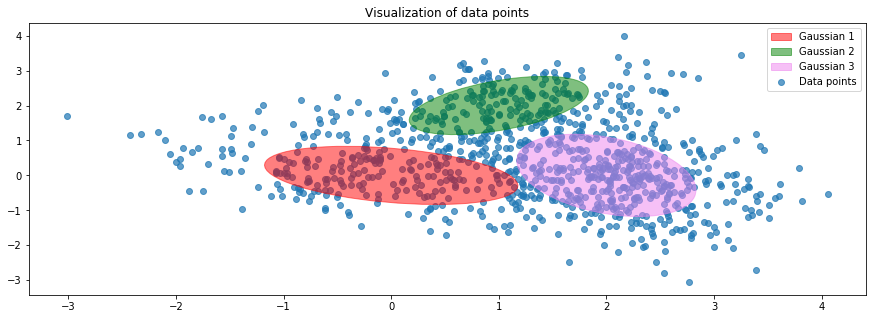

In [7]:
plt.figure(figsize=(15,5))
ax = plt.gca()

# Plot the data-points
ax.scatter(x[:, 0], x[:, 1], alpha=.7, label="Data points")
ax.set_title("Visualization of data points")
    
colors = ["r", "g", "violet"]
for i, (pos, covar, w, color) in enumerate(zip(mu_0, sigma_0, pi_0, colors)):
    draw_ellipse(pos, covar, ax=ax, alpha=.5, color=color, label="Gaussian %d" % (i + 1))
        
ax.legend()
plt.show()

<div class="alert alert-success">

2 - Implement the EM algorithm for GMMs (be careful about numerical stability!).
</div>

In [8]:
def m_step(gamma_val, x, N, K):
    """
    Execute the M-step of EM algorithm
    
    Parameters
    ----------
    gamma_val : `numpy.array`, shape (N, K)
        Gamma of the E-step
        
    x : `numpy.array`, shape (N, m=2)
        The data point
        
    N : `int`
        Number of data-points
        
    K : `int`
        Number of gaussians

    Returns
    -------
    pi : `numpy.array`, shape (K,)
        The weights of the gaussians
    
    mu : `numpy.array`, shape (K, m)
        The means of the gaussians
        
    sigma : `numpy.array`, shape (K, m, m)
        The covariances of the gaussians
    """
    
    m = x.shape[1] # The dimension of each x_n
    
    sum_gamma = np.sum(gamma_val, axis=0).reshape(-1,1) # Sum of gammas
    
    mu = gamma_val.T.dot(x) / sum_gamma
    pi = sum_gamma.reshape(-1) / N
        
    sigma = np.zeros((K, m, m))
    for k in range(K):
        tmp = np.array([x[n] - mu[k] for n in range(N)])
        sigma[k] = np.multiply(tmp.T,  gamma_val[:,k].reshape(-1,1).T).dot(tmp) / sum_gamma[k]
    
    return pi, mu, sigma

def em(pi, mu, sigma, N, K, number_of_iterations=50, epsilon=1e-2):
    """
    Execute the M-step of EM algorithm
    
    Parameters
    ----------
    pi : `numpy.array`, shape (K,)
        The initial weights of the gaussians
    
    mu : `numpy.array`, shape (K, m)
        The initial means of the gaussians
        
    sigma : `numpy.array`, shape (K, m, m)
        The initial covariances of the gaussians
        
    N : `int`
        Number of data-points
        
    K : `int`
        Number of gaussians
        
    number_of_iterations : `int`, default=50
        Number of iterations required to stop the algorithm
        
    epsilon : `float`, default=1e-2
        The order of the difference between likelihoods to stop the algorithm

    Returns
    -------
    pi : `numpy.array`, shape (K,)
        The weights of the gaussians
    
    mu : `numpy.array`, shape (K, m)
        The means of the gaussians
        
    sigma : `numpy.array`, shape (K, m, m)
        The covariances of the gaussians
        
    log_likelihoods : `numpy.array`, shape (K,)
        The log-likehood at each iteration
    """
    
    log_likelihoods = [] # Initial the list to keep track of the log-likelihoods
    
    # Define the plot figure size
    plt.figure(figsize=(20, number_of_iterations*5 // 4))
    
    # Define the colors to use for each gaussian in drawing the ellipses
    np.random.seed(90)
    colors = [np.random.rand(3) for i in range(K)]
    if (K == 3):
        colors = ["r", "g", "violet"]
    
    for t in range(number_of_iterations):
        
        
        # Start plotting
        ax = plt.subplot(number_of_iterations // 4, 4, t+1)
        
        # Plot the data-points
        ax.scatter(x[:, 0], x[:, 1], alpha=.5, label="Data points")
        #ax.axis('equal')
        ax.set_title("Iteration %d" % (t + 1))
    
        for i, (pos, covar, w, color) in enumerate(zip(mu, sigma, pi, colors)):
            draw_ellipse(pos, covar, ax=ax, alpha=.5, color=color, label="Gaussian %d" % (i + 1))
        
        ax.legend()
        # End plotting
        
        
        # E-step
        log_likelihood = np.zeros((N, K)) # Initialize the log-likelihood vector
        gamma_val = np.zeros((N, K)) # Initialize the Gamma vector
        for n in range(N):
            gamma_val[n], log_likelihood[n] = gamma(x[n], pi, mu, sigma)

        # We sum the elements of 'log_likelihood' to obtain the log-likelihood
        # Then we add it to the list
        log_likelihoods.append(log_likelihood.sum())
        # End of E-step

        # M-step
        pi, mu, sigma = m_step(gamma_val, x, N, K)
        # End of M-step
        
        # Stop condition
        if ((len(log_likelihoods) > 1) and (np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < epsilon)):
            break
    
    plt.gca()
    plt.show() # Plot the figures
    return pi, mu, sigma, log_likelihoods

<div class="alert alert-success">

a) Forget about the true parameters $\pi_{1:K}$,$\mu_{1:K}$, and $\Sigma_{1:K}$ for now. By only considering the dataset $\{x_n\}_{n=1}^N$ that is generated in the previous step, run the EM algorithm after randomly initializing the parameter
estimates $\pi_{1:K}^{(0)}$,$\mu_{1:K}^{(0)}$, and $\Sigma_{1:K}^{(0)}$. Visualize the intermediate results by plotting the contours of the estimated Gaussians.
</div>

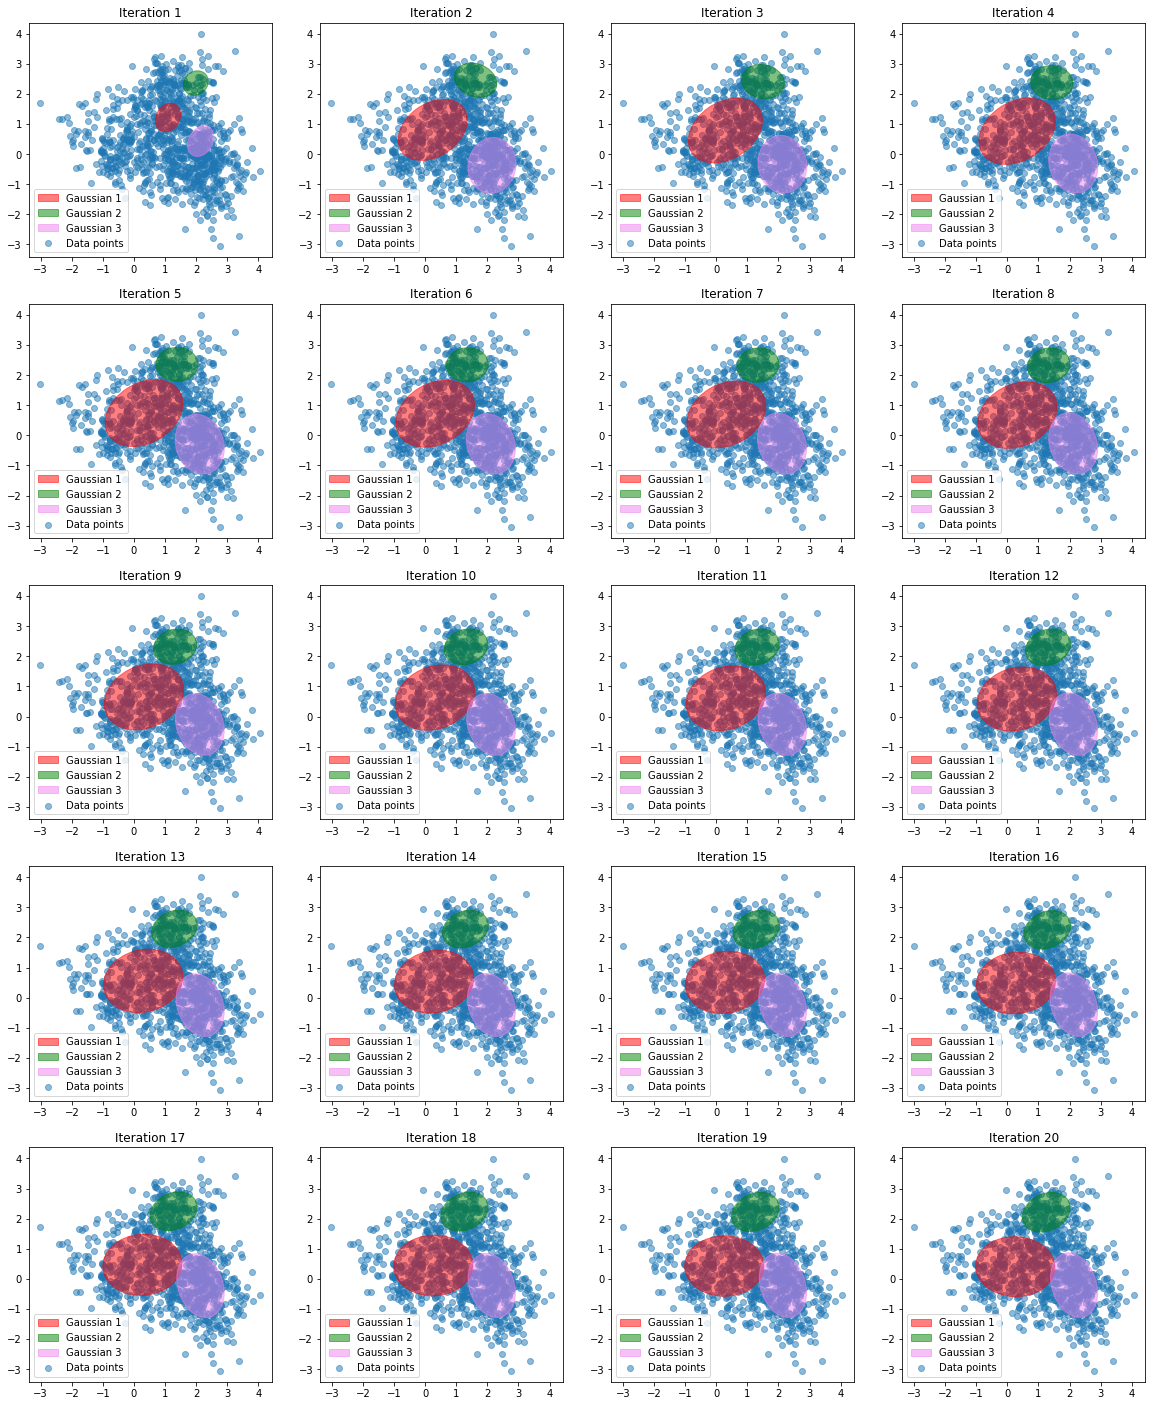

In [9]:
K = 3 # Number of gaussians

# Take K random values between 0 and 1 then normalize to get a probability/weight
pi = np.random.rand(K)
pi /= np.sum(pi)

# We choose random vectors of X to generate the mean of the gaussians
mu = x[np.random.choice(N, K, False)].copy()

# Generate the covariance matrix by taking a random vector (2, 2)
# then multiply it by its transpose to get a symmetric matrix
# then we add the identity to have a definite symmetric matrix
# and finally we normalize
sigma = []
for k in range(K):
    tmp = np.random.rand(2, 2)
    sigma.append(tmp.T.dot(tmp) + np.identity(2))
    
sigma = np.array(sigma) / np.sum(sigma)

# Perfom the EM algorithm
pi_1, mu_1, sigma_1, log_likelihoods = em(pi, mu, sigma, N, K, 20)

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">COMMENT</span><br><br>
     We can see that the algorithm doesn't need many iterations to converge. In the beginning, the contours are small and then they start getting bigger and bigger until the gaussians cover the data. 
</div>

<div class="alert alert-success">

b) While running the EM algorithm, compute the log-likelihood. Plot the log-likelihood vs iterations (be careful about numerical stability!).
</div>

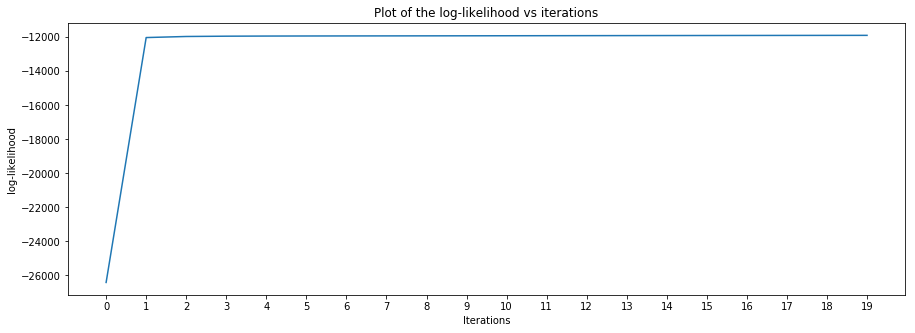

In [10]:
plt.figure(figsize=(15,5))
plt.plot(log_likelihoods)
plt.title('Plot of the log-likelihood vs iterations')
plt.xlabel('Iterations')
plt.ylabel('log-likelihood')
plt.xticks(range(20))
plt.show()

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">COMMENT</span><br><br>
     The likelihood converges in few iterations to its maximum. By looking at the log-likelihood axis, we can see that the likelihood is very small.
</div>

<div class="alert alert-success">

c) Run the EM algorithm with different initializations for $\pi_{1:K}^{(0)}$,$\mu_{1:K}^{(0)}$, and $\Sigma_{1:K}^{(0)}$. How sensitive is the algorithm for different initial values?
</div>

<div class="alert alert-warning">
Let's try to initialize the means of the gaussians with $0$:
</div>

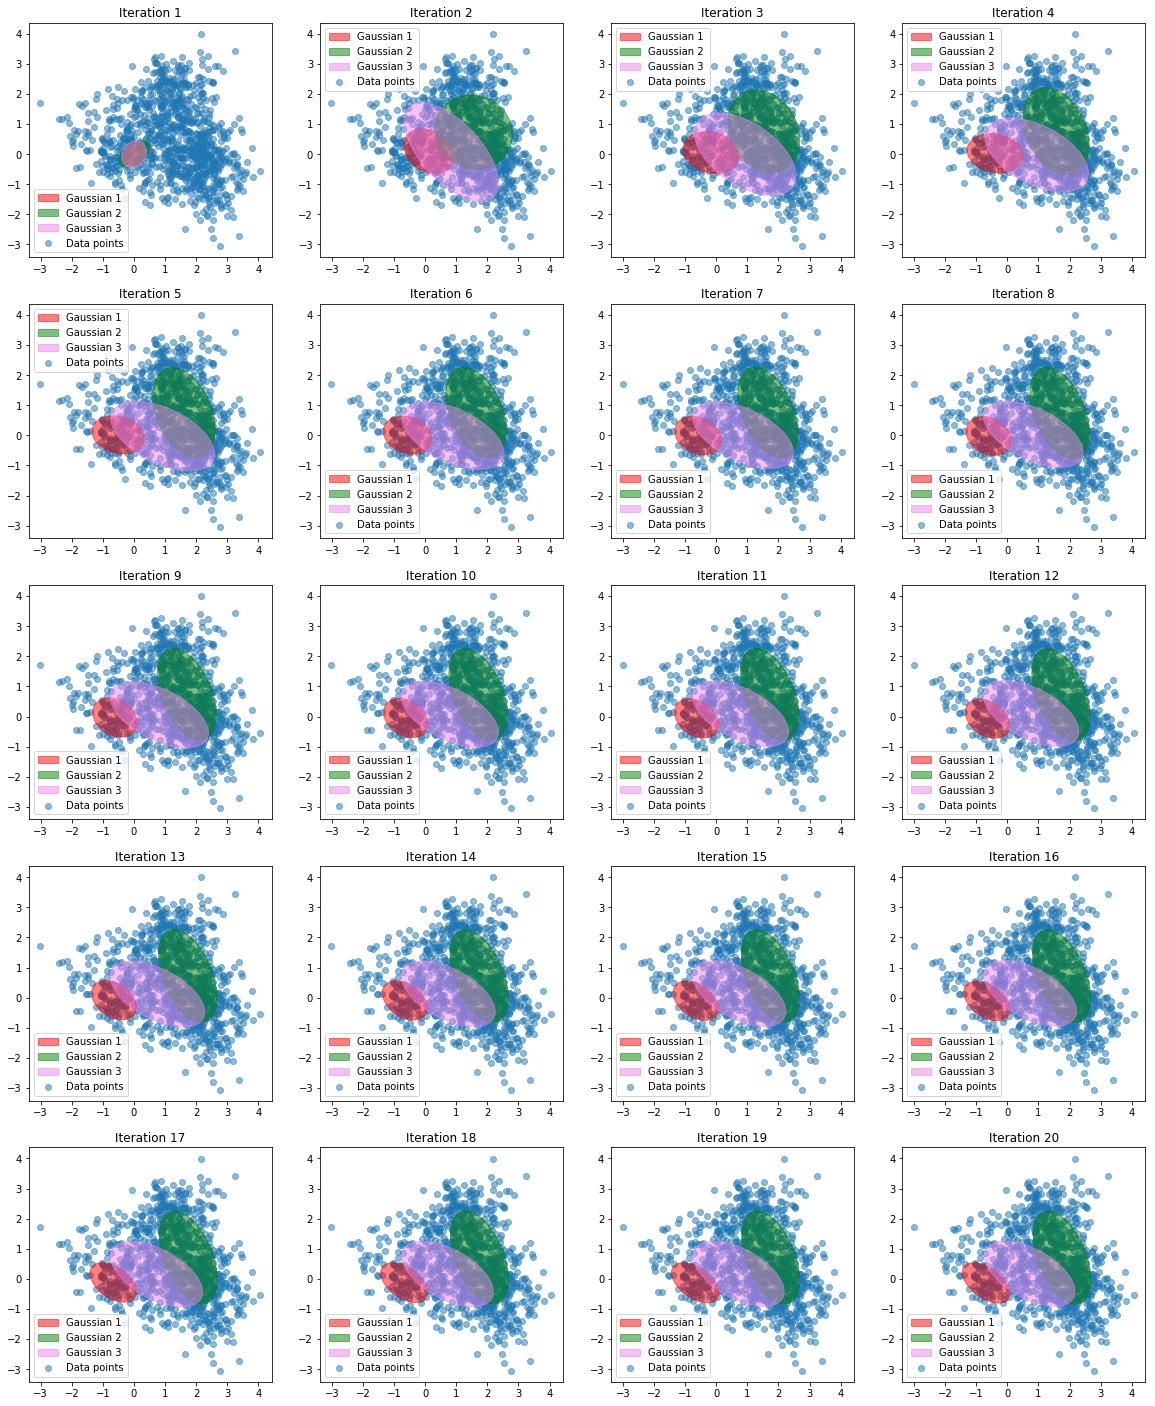

In [11]:
K = 3 # Number of gaussians

# Take K random values between 0 and 1 then normalize to get a probability/weight
pi = np.random.rand(K)
pi /= np.sum(pi)

# We choose random vectors of X to generate the mean of the gaussians
mu = np.zeros((K, 2))

# Generate the covariance matrix by taking a random vector (2, 2)
# then multiply it by its transpose to get a symmetric matrix
# then we add the identity to have a definite symmetric matrix
# and finally we normalize
sigma = []
for k in range(K):
    tmp = np.random.rand(2, 2)
    sigma.append(tmp.T.dot(tmp) + np.identity(2))
    
sigma = np.array(sigma) / np.sum(sigma)

# Perfom the EM algorithm
pi_2, mu_2, sigma_2, _ = em(pi, mu, sigma, N, K, 20)

<div class="alert alert-warning">

<p>
Let's try to initialize the means using a trick common in $K$-means algorithms (known as $K$-means++):
    
</p>
<ol>
<li>We choose a data point at random from the dataset as the mean for the first Gaussian</li>
<li>We compute the squared euclidean distance of all other data points to the first Gaussian mean</li>
<li>In order to choose the second Gaussian mean, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (a normalization to make sure the probability adds up to 1). This means that the new mean should be as far as possible from the other Gaussians' mean</li>
<li>Next, we recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the third Gaussian, we compare the data point's distance between the first and second Gaussians means and choose the smaller one)</li>
<li>We repeat step 3 and 4 until we have $K$ initial Gaussians means.</li>
</ol>
</div>

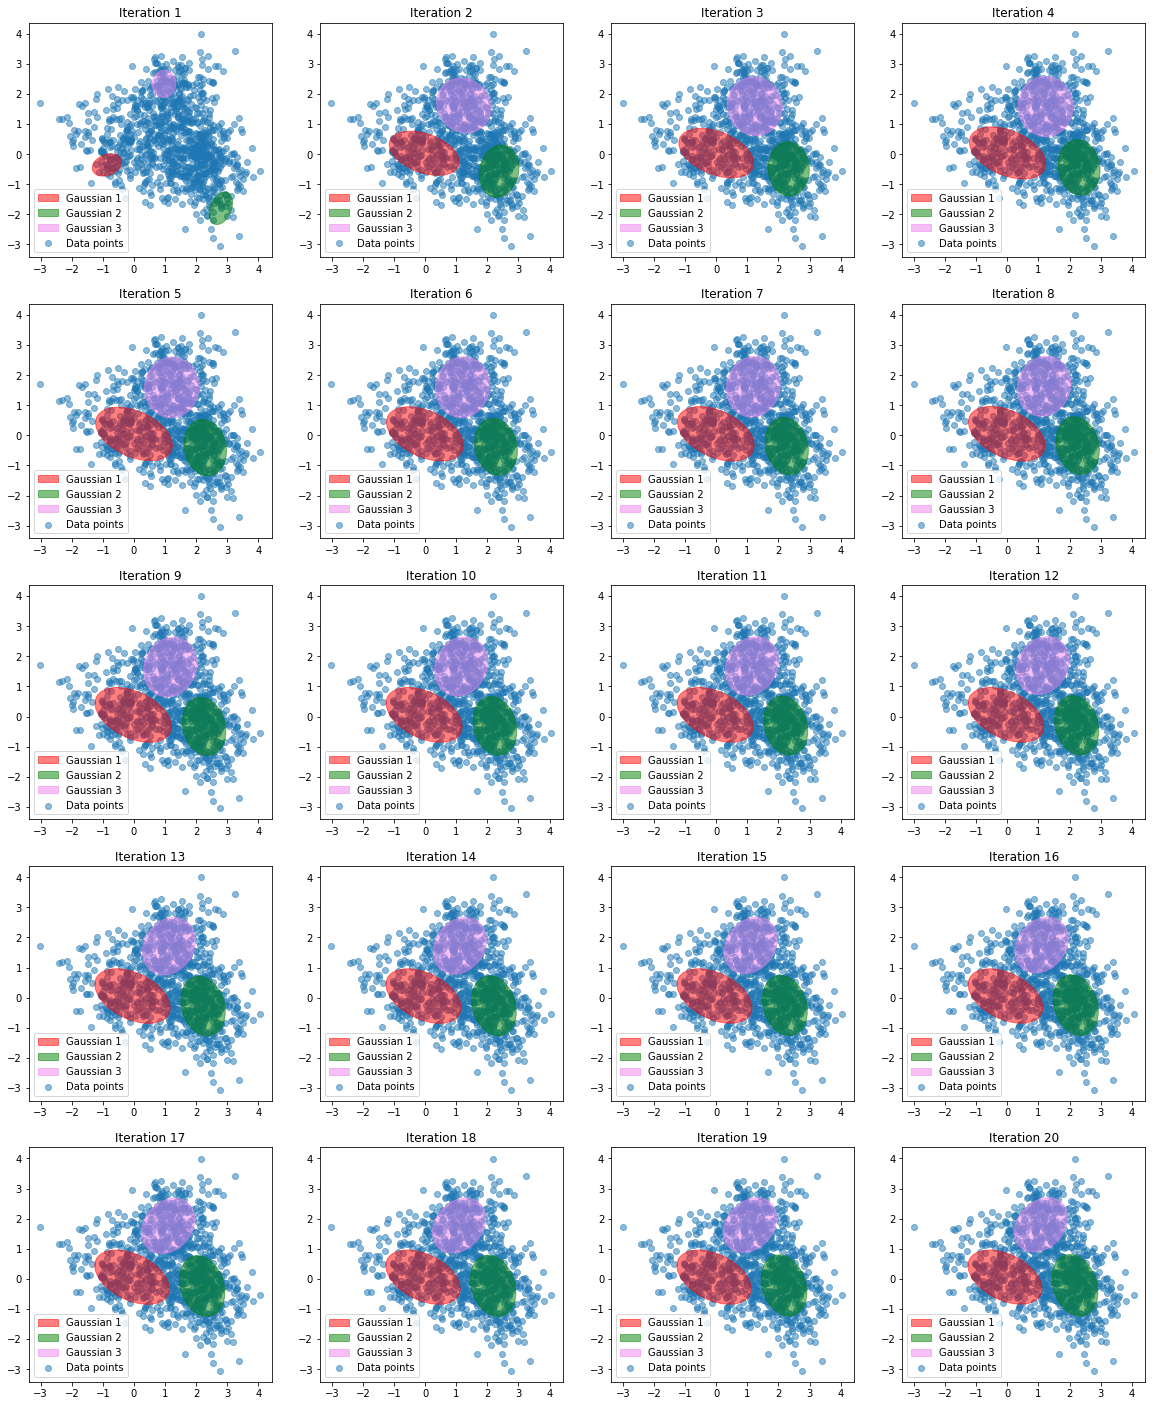

In [12]:
K = 3 # Number of gaussians

# Take K random values between 0 and 1 then normalize to get a probability/weight
pi = np.random.rand(K)
pi /= np.sum(pi)

# We choose random vectors of X to generate the mean of the gaussians
mu = np.zeros((K, 2))
mu[0] = x[np.random.choice(N)].copy()
for i in range(1, K):
    distance_matrix = np.array([[np.linalg.norm(x[l]-mu[j])**2 for j in range(i)] for l in range (N)])
    minDistances = np.min(distance_matrix, axis=1)
    probability = minDistances / np.sum(minDistances)
    mu[i] = x[np.random.choice(N, p=probability)]  

# Generate the covariance matrix by taking a random vector (2, 2)
# then multiply it by its transpose to get a symmetric matrix
# then we add the identity to have a definite symmetric matrix
# and finally we normalize
sigma = []
for k in range(K):
    tmp = np.random.rand(2, 2)
    sigma.append(tmp.T.dot(tmp) + np.identity(2))
    
sigma = np.array(sigma) / np.sum(sigma)

# Perfom the EM algorithm
pi_3, mu_3, sigma_3, _ = em(pi, mu, sigma, N, K, 20)

<div class="alert alert-warning">

We're going to visualize the data with the three initialization we've performed to compare them to the ($\pi$, $\mu$, $\Sigma$) we used to generate the data:
</div>

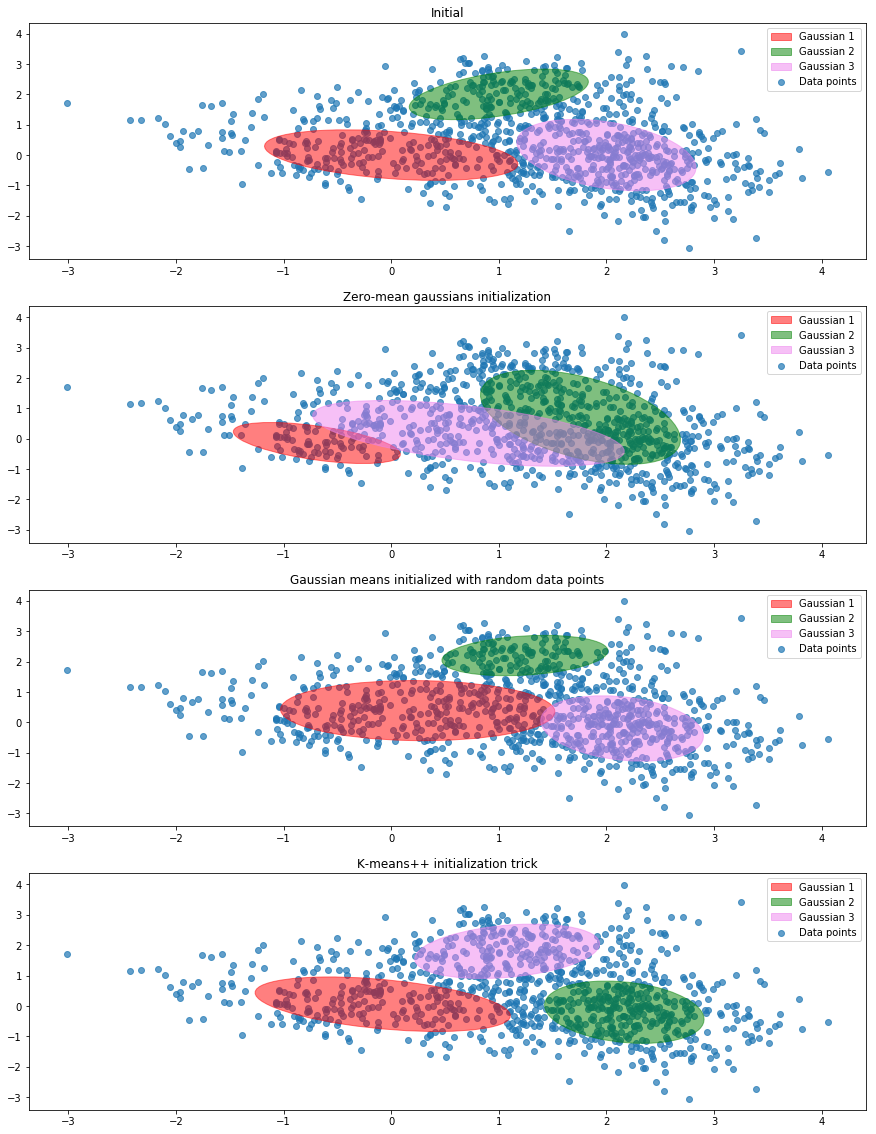

In [13]:
models = {
    "Initial": [pi_0, mu_0, sigma_0],
    "Zero-mean gaussians initialization": [pi_2, mu_2, sigma_2],
    "Gaussian means initialized with random data points": [pi_1, mu_1, sigma_1],
    "K-means++ initialization trick": [pi_3, mu_3, sigma_3]
}

plt.figure(figsize=(15,20))

for j, key in enumerate(models):
    plt.subplot(4, 1, j+1)
    ax = plt.gca()

    # Plot the data-points
    ax.scatter(x[:, 0], x[:, 1], alpha=.7, label="Data points")
    ax.set_title(key)

    colors = ["r", "g", "violet"]
    for i, (pos, covar, w) in enumerate(zip(models[key][1], models[key][2], models[key][0])):
        draw_ellipse(pos, covar, ax=ax, alpha=.5, color=colors[i], label="Gaussian %d" % (i + 1))

    ax.legend()
plt.show()

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">COMMENT</span><br><br>
The EM algorithm for Gaussian Mixture models converges to a local optimum and not to a global one. So it's normal that the algorithm may miss the globally optimal solution. Therefore, the algorithm is sensitive to initial values. We can see that the $K$-means++ initialization trick allows the algorithm to converge to the global minimum. With other initialization, we can see that the algorithm converged to different local minima.
</div>